# Python for Geospatial Analysis Assignment
Christoffer Bøgelund Rasmussen

## Raster analysis
### 1. Write a function that plots the projected total and urban population from 2010 to 2100 for a selected country as a line chart. The attached countries.tif contains the country ID for each cell; this list shows which ID is which country

In [1]:
# Import various python modules
import rasterio
import bokeh
import urllib.request
import zipfile
import os
import glob
import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline 

Open the tif file containing the ISO codes

In [2]:
# Open the countries.tif file
countries_tif = rasterio.open("countries.tif")

# Print various attributes about the dataset
print("Dataset name: {}".format(countries_tif.name))
print("Width: {}, Height: {}".format(countries_tif.width, countries_tif.height))
print("World extent: {}".format(countries_tif.bounds))
print("CRS: {}".format(countries_tif.crs))

# Determine the number of layers and the datatype of the given layers
print("Dataset bands and datatypes: {}".format({i: dtype for i, 
                                                dtype in zip(countries_tif.indexes, 
                                                             countries_tif.dtypes)}))

Dataset name: countries.tif
Width: 2880, Height: 1117
World extent: BoundingBox(left=-180.0, bottom=-55.875, right=180.0, top=83.75)
CRS: EPSG:4326
Dataset bands and datatypes: {1: 'float64'}


Show the different countries based on the ISO code

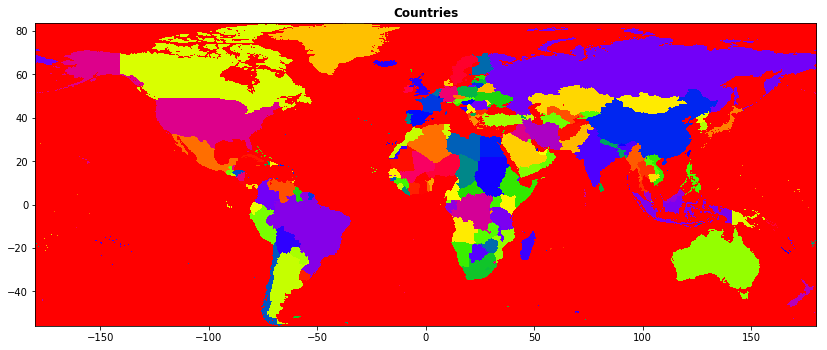

In [3]:
# Show the layer
plt.figure(figsize=(14, 14))
show((countries_tif, 1), title='Countries', cmap='prism')

Show the various ISO codes in the extracted band

In [4]:
iso_band = countries_tif.read(1)
print(np.unique(iso_band))

[-99.   4.   8.  12.  16.  24.  28.  31.  32.  36.  40.  44.  48.  50.
  51.  52.  56.  60.  64.  68.  70.  72.  76.  84.  86.  90.  92.  96.
 100. 104. 108. 112. 116. 120. 124. 132. 136. 140. 144. 148. 152. 156.
 158. 170. 174. 178. 180. 184. 188. 191. 192. 196. 203. 204. 208. 212.
 214. 218. 222. 226. 231. 232. 233. 234. 238. 239. 242. 246. 248. 250.
 258. 260. 262. 266. 268. 270. 275. 276. 288. 292. 296. 300. 304. 308.
 316. 320. 324. 328. 332. 334. 336. 340. 344. 348. 352. 356. 360. 364.
 368. 372. 376. 380. 384. 388. 392. 398. 400. 404. 408. 410. 414. 417.
 418. 422. 426. 428. 430. 434. 438. 440. 442. 446. 450. 454. 458. 462.
 466. 470. 478. 480. 484. 492. 496. 498. 499. 500. 504. 508. 512. 516.
 520. 524. 528. 531. 533. 534. 540. 548. 554. 558. 562. 566. 570. 574.
 580. 581. 583. 584. 585. 586. 591. 598. 600. 604. 608. 612. 616. 620.
 624. 626. 630. 634. 642. 643. 646. 652. 654. 659. 660. 662. 663. 666.
 670. 674. 678. 682. 686. 688. 690. 694. 702. 703. 704. 705. 706. 710.
 716. 

A number of different functions that ends out in plotting the total and urban population

In [5]:
def showCountryISO(iso, rasterband):
    """
    Function to plot the country defined by the ISO code given a raster band
    
    Inputs
    ======
    arg1 : int
        ISO code
    arg2 : NumPy Array
        Array consisting of ISO codes defining locations of countries on a world map
    
    Outputs
    =======
    None. A matplotlib figure is shown.
    """
    # Check if ISO code is in the band
    if iso in rasterband:
        print("ISO code {} exists in raster file".format(str(iso)))
        
        # Index xy coordinates of the ISO code in the raster file
        iso_coords = np.where(rasterband == iso)

        # Create an empty array
        iso_map = np.zeros(rasterband.shape, dtype=rasterband.dtype)
        # Set the coords of the country to 1
        iso_map[iso_coords] = 1

        # Show the figures with the given ISO
        plt.figure(figsize=(14, 14))
        plt.title("Country ISO {}".format(iso))
        plt.imshow(iso_map)
        
        return iso_coords

    else:
        print("ISO code {} is not in raster file".format(iso))
        print("Choose one of the following and try again")
        print(np.unique(rasterband))    
        
def getTifFiles(tif_dir, pop_type):
    """
    Function to extract all tif files in a directory
    
    Inputs
    ======
    arg1 : String
        Directory to search for tif files
    arg2 : String
        Type of population - simply for printing purposes
    
    Ouputs
    ======
    A list containing all files names with the tif extension
    """
    # Get all tif files in the directory
    tif_lst = []
    for file in os.listdir(tif_dir):
        if file.endswith(".tif"):
            tif_lst.append(file)
    print("Number of {} tif files: {}".format(pop_type, len(tif_lst)))
    print("Spanning from {} to {}".format(os.path.splitext(tif_lst[0])[0][-4:], 
                                          os.path.splitext(tif_lst[-1])[0][-4:]))
    return tif_lst

def removeOutliersRaster(raster, perc_bound = 0.1):
    """
    Function to check for outliers in the raster file. If any exist they are set to 0
    Likely the outliers are errors in the data.
    
    Inputs
    ======
    arg1 : NumPy array
        Array of values containing, in this case, population data
    arg2 : Float (optional)
        Definition of the lower and upper bounds. 
        I.e. 0.0 + perc_bound & 100.0 - perc_bound.
        By standard set at very low as function catches extreme errors 
        in the array (overflow/underflow)
        
    Outputs
    =======
    A NumPy array with any outliers set to 0
    """
    from copy import deepcopy
    outlier_raster = deepcopy(raster)
    # Define upper and lower bounds
    q1, q3 = np.percentile(np.unique(outlier_raster),[0.0 + perc_bound, 100.0 - perc_bound])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr) 
    upper_bound = q3 + (1.5 * iqr) 

    # Check if any values are greater or lower than bounds. If so set to 0
    if any(np.unique(outlier_raster) > upper_bound):
        outlier_raster[np.where(outlier_raster > upper_bound)] = 0

    if any(np.unique(outlier_raster) < lower_bound):
        outlier_raster[np.where(outlier_raster < upper_bound)] = 0
        
    return outlier_raster

def extractPopulationData(pop_type, iso_coords):
    """
    Function to loop over a number of tif files and return the total population for a
    country and the year in which the data was extracted
    
    Inputs
    ======
    arg1 : String
        Type of population to extract
        Options: ['Total', 'Urban']
    arg2 : NumPy Array
        xy-coordinates based on the countries raster of where the country is located given 
        an ISO code
        
    Outputs
    =======
    Two lists containing the sum of the population for the ISO code and another with the 
    corresponding years
    """
    # Location to the tif file
    tif_dir = os.path.join(os.getcwd(), 'SSP4', pop_type, 'GeoTIFF')    
    tif_lst = getTifFiles(tif_dir, pop_type)

    # Loop the files
    pop_lst = []
    years_lst = []
    for t_idx, t_file in enumerate(tif_lst):
        # Read the tif file
        tif = rasterio.open(os.path.join(tif_dir, t_file))

        # Extract the band containing the data
        data_band = tif.read(1)

        # Empty array to fill in only the data for the given ISO code
        iso_pop = np.zeros(data_band.shape, dtype=data_band.dtype)
        iso_pop[iso_coords] = data_band[iso_coords]
        
        # Check for outliers and remove any
        iso_pop = removeOutliersRaster(iso_pop)
        
        # Sum the urban population for the country
        pop = np.sum(iso_pop)
        pop_lst.append(pop)
        year = os.path.splitext(tif_lst[t_idx])[0][-4:]
        years_lst.append(year)
        
    print("Completed extracting population data for {}".format(pop_type))
    print(pop_lst)
    print(years_lst)
    return pop_lst, years_lst

def plotPopulation(iso_code, iso_band):
    """
    Function to extract the population data and plot the resulting data
    
    Inputs
    ======
    arg1 : integer
        ISO code for a country
    arg2 : NumPy array 
        Definition of locations of countries on a world map based on their ISO code
    
    Outputs
    =======
    None. A figure is shown containing a line chart of trends for total
    and urban population for the given ISO code country
    """
    # Get the ISO xy-coords
    iso_coords = showCountryISO(iso_code, iso_band)
    
    # Extract data of the population trends
    total_pop_lst, years_lst = extractPopulationData('Total', iso_coords)
    urban_pop_lst, years_lst = extractPopulationData('Urban', iso_coords)

    # Plot the population statistics
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(years_lst, urban_pop_lst, label='Urban')
    ax.plot(years_lst, total_pop_lst, label='Total')
    ax.legend()
    ax.set_xlabel("Year")
    ax.set_ylabel("Population")
    fig.suptitle("Population trend for ISO {}".format(iso_code))
    

Finally, based on an ISO code show only that country plotted on the world map and plot the population projections

ISO code 288 exists in raster file
Number of Total tif files: 10
Spanning from 2010 to 2100
Completed extracting population data for Total
[24215184, 30531514, 37842459, 45664150, 53720830, 61470045, 68810663, 75685778, 81883862, 87357406]
['2010', '2020', '2030', '2040', '2050', '2060', '2070', '2080', '2090', '2100']
Number of Urban tif files: 10
Spanning from 2010 to 2100
Completed extracting population data for Urban
[12486556, 18519707, 25869267, 34224442, 43043479, 51760961, 60266116, 68100000, 75152955, 81533502]
['2010', '2020', '2030', '2040', '2050', '2060', '2070', '2080', '2090', '2100']


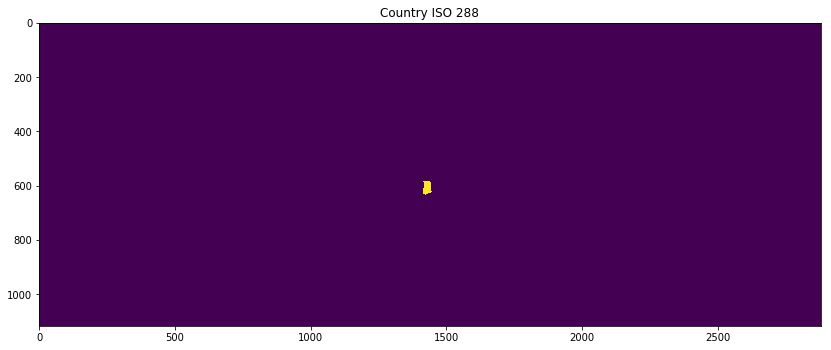

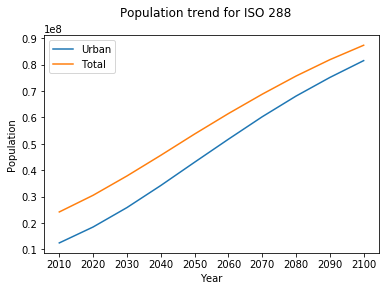

In [6]:
# Define ISO 
iso_code = 288
plotPopulation(iso_code, iso_band)

### 2. Generate a global raster that shows only the cells that are projected to lose population, and indicates how much the population in those cells is projected to decline between 2010 and 2100.

In [7]:
# Load the raster for 2010 and 2100
# Location to the tif file
pop_type = 'Total'
tif_dir = os.path.join(os.getcwd(), 'SSP4', pop_type, 'GeoTIFF')    
tif_lst = getTifFiles(tif_dir, pop_type)

# Read the two files
tif_2010 = rasterio.open(os.path.join(tif_dir, tif_lst[0]))
tif_2100 = rasterio.open(os.path.join(tif_dir, tif_lst[-1]))

# Extract the band2 containing the data
data_band_2010 = tif_2010.read(1)
data_band_2100 = tif_2100.read(1)

# Remove outliers in both rasters
data_band_2010 = removeOutliersRaster(data_band_2010)
data_band_2100 = removeOutliersRaster(data_band_2100)

# Subtract 2100 raster from 2010
data_band_diff = data_band_2100 - data_band_2010

# Set all positive values to 0. I.e. cells with population increase
pos_pop_coords = np.where(data_band_diff >= 0)
data_band_diff[pos_pop_coords] = 0

Number of Total tif files: 10
Spanning from 2010 to 2100


Text(0.5, 1.0, 'Projected decreasing population trends between 2010 and 2100')

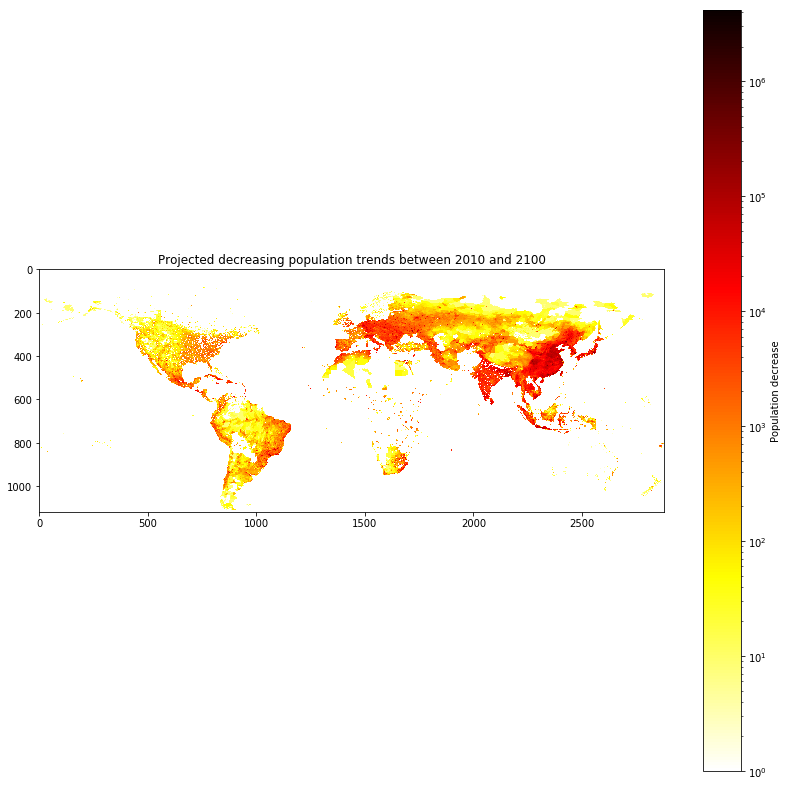

In [8]:
# Show the raster with decreasing population
from matplotlib.colors import LogNorm
plt.figure(figsize=(14, 14))
plt.imshow(abs(data_band_diff), norm=LogNorm(), cmap='hot_r')
cb = plt.colorbar()
cb.set_label("Population decrease")
plt.title("Projected decreasing population trends between 2010 and 2100".format(iso_code))

Save the global raster with the cells projecting population decline

In [9]:
# Save the result
save_loc = os.path.join(os.getcwd(), 'decline_pop.tif')
with rasterio.open(
    save_loc,
    'w',
    driver='GTiff',
    height=data_band_diff.shape[0],
    width=data_band_diff.shape[1],
    count=1,
    dtype=data_band_diff.dtype,
    crs=tif_2010.crs, 
    transform = tif_2010.transform
) as dst:
    dst.write(data_band_diff, 1)
    
# Check if the saved file is identical by opening it and comparing it to the result
saved_pop_diff = rasterio.open(save_loc)
if np.array_equal(saved_pop_diff.read(1), data_band_diff):
    print("Population decline raster saved correctly at {}".format(save_loc))
else:
    print("Error in writing the results")

Population decline raster saved correctly at C:\Users\I004586\Desktop\geospatial_phd\assignment\decline_pop.tif


## Spatial autocorrelation
### 1. Download a shapefile of the world from naturalearthdata.com and perform a left join with the attached under5mortality.csv , which contains child mortality rates for each country in the world. The join should be done on the ISO_A3 column in the shapefile and the ISO column in the CSV, respectively.

In [10]:
# Read the shapefile as a GeoPandas dataframe
import geopandas as gpd 

fp = os.path.join(os.getcwd(), 'worldshapefile', 'ne_110m_admin_0_countries.shp') 
world_df = gpd.read_file(fp)

# Output some of the data
print ("The type of data is", type(world_df))
print(world_df.head(2)) 
print(world_df.keys())

The type of data is <class 'geopandas.geodataframe.GeoDataFrame'>
        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   

   ADM0_DIF  LEVEL               TYPE                        ADMIN ADM0_A3  \
0         0      2  Sovereign country                         Fiji     FJI   
1         0      2  Sovereign country  United Republic of Tanzania     TZA   

   ...       NAME_KO   NAME_NL   NAME_PL    NAME_PT           NAME_RU  \
0  ...        í¼ì§      Fiji    FidÅ¼i       Fiji        Ð¤Ð¸Ð´Ð¶Ð¸   
1  ...  íìëì  Tanzania  Tanzania  TanzÃ¢nia  Ð¢Ð°Ð½Ð·Ð°Ð½Ð¸Ñ   

    NAME_SV   NAME_TR   NAME_VI       NAME_ZH  \
0      Fiji      Fiji      Fiji        ææ¿   
1  Tanzania  Tanzanya  Tanzania  å¦æ¡å°¼äº   

                                            geometry  
0  (POLYGON ((180 -16.0671326636424

In [11]:
# Import the csv file
import pandas as pd

csv_loc = os.path.join(os.getcwd(), 'under5mortality.csv')
mortality_df = pd.read_csv(csv_loc)

# Output some of the data
print ("The type of data is", type(mortality_df))
print(mortality_df.head(2)) 
print(mortality_df.keys())

The type of data is <class 'pandas.core.frame.DataFrame'>
   Unnamed: 0  ISO         Name  ChildMortality
0           1  AFG  Afghanistan            67.9
1           4  ALB      Albania             8.8
Index(['Unnamed: 0', 'ISO', 'Name', 'ChildMortality'], dtype='object')


In [12]:
# Change the key name in the mortality dataframe to match the world dataframe
mortality_df['ISO_A3'] = mortality_df.pop('ISO')

# Perform a left merge
merged_df = pd.merge(world_df, mortality_df, on='ISO_A3', how='left')

# Output some of the data
print ("The type of data is", type(merged_df))
print(merged_df.head(3)) 
print(merged_df.keys())

The type of data is <class 'geopandas.geodataframe.GeoDataFrame'>
        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   

   ADM0_DIF  LEVEL               TYPE                        ADMIN ADM0_A3  \
0         0      2  Sovereign country                         Fiji     FJI   
1         0      2  Sovereign country  United Republic of Tanzania     TZA   
2         0      2      Indeterminate               Western Sahara     SAH   

   ...          NAME_PT                        NAME_RU      NAME_SV  \
0  ...             Fiji                     Ð¤Ð¸Ð´Ð¶Ð¸         Fiji   
1  ...        TanzÃ¢nia               Ð¢Ð°Ð½Ð·Ð°Ð½Ð¸Ñ     Tanzania   
2  ...  Saara Ocidental  ÐÐ°Ð¿Ð°Ð´Ð½Ð°Ñ Ð¡Ð°ÑÐ°ÑÐ°  VÃ¤stsahara   

       NAME_TR 

### 2. Calculate the spatial weights matrix for the world based on border neighborhood and use the weights to calculate Moran's I for child mortality.

In [13]:
from pysal.lib import weights
from pysal.explore import esda
#from pysal.viz import mapclassify
#from pysal.viz.splot.mapping import vba_choropleth
#from pysal.explore import esda

C:\Users\I004586\AppData\Local\Continuum\anaconda3\envs\geospatial_assignment\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


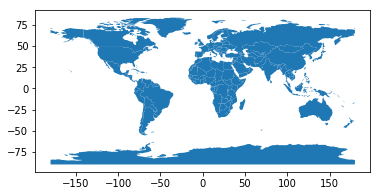

In [14]:
merged_df.plot()

In [15]:
# Set Nan values to 0
mort_final_df = merged_df
child_mort = merged_df['ChildMortality']
nan_idx = np.where(np.isnan(child_mort))[0]

mort_final_df['ChildMortality'][nan_idx] = 0
mort_final_df.head(5)

C:\Users\I004586\AppData\Local\Continuum\anaconda3\envs\geospatial_assignment\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry,Unnamed: 0,Name,ChildMortality
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,Fiji,FJI,...,Fiji,Ð¤Ð¸Ð´Ð¶Ð¸,Fiji,Fiji,Fiji,ææ¿,"(POLYGON ((180 -16.06713266364245, 180 -16.555...",181.0,Fiji,25.3
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,United Republic of Tanzania,TZA,...,TanzÃ¢nia,Ð¢Ð°Ð½Ð·Ð°Ð½Ð¸Ñ,Tanzania,Tanzanya,Tanzania,å¦æ¡å°¼äº,POLYGON ((33.90371119710453 -0.950000000000000...,559.0,United Republic of Tanzania,54.0
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,Western Sahara,SAH,...,Saara Ocidental,ÐÐ°Ð¿Ð°Ð´Ð½Ð°Ñ Ð¡Ð°Ñ Ð°ÑÐ°,VÃ¤stsahara,BatÄ± Sahra,TÃ¢y Sahara,è¥¿æåæ,POLYGON ((-8.665589565454809 27.65642588959236...,NaN,NaN,0.0
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,Canada,CAN,...,CanadÃ¡,ÐÐ°Ð½Ð°Ð´Ð°,Kanada,Kanada,Canada,å æ¿å¤§,"(POLYGON ((-122.84 49.00000000000011, -122.974...",97.0,Canada,5.1
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,United States of America,USA,...,Estados Unidos,Ð¡Ð¾ÐµÐ´Ð¸Ð½ÑÐ½Ð½ÑÐµ Ð¨ÑÐ°ÑÑ ÐÐ¼ÐµÑÐ¸ÐºÐ¸,USA,Amerika BirleÅik Devletleri,Hoa Ká»³,ç¾å½,"(POLYGON ((-122.84 49.00000000000011, -120 49....",562.0,United States,6.6


In [16]:
# Queen weights
w_queen = weights.Queen.from_dataframe(mort_final_df)

# K-NN weights
w_k1 = weights.KNN.from_dataframe(mort_final_df, k=1)

C:\Users\I004586\AppData\Local\Continuum\anaconda3\envs\geospatial_assignment\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 21 disconnected observations 
  Island ids: 0, 19, 20, 22, 23, 45, 46, 47, 78, 89, 134, 135, 136, 137, 138, 140, 144, 147, 155, 159, 175
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))
C:\Users\I004586\AppData\Local\Continuum\anaconda3\envs\geospatial_assignment\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 46 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


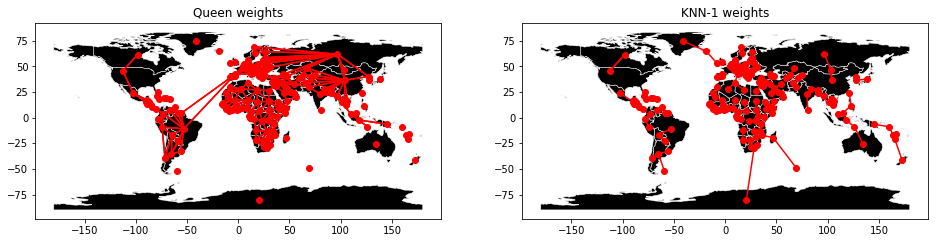

In [17]:
f, axs = plt.subplots(1, 2, figsize=(16, 8))

mort_final_df.plot(color='k', ax=axs[0], 
        edgecolor='w', linewidth=0.5)
w_queen.plot(mort_final_df, ax=axs[0], color='red')
axs[0].set_title('Queen weights')

mort_final_df.plot(color='k', ax=axs[1], 
        edgecolor='w', linewidth=0.5)
w_k1.plot(mort_final_df, ax=axs[1], color='red')
axs[1].set_title('KNN-1 weights')

plt.show()

In [18]:
# Determine indices where mortality is NaN
child_mort = merged_df['ChildMortality']
nan_idx = np.where(np.isnan(child_mort))[0]
# Remove entire row from database if childmortality is nan
nan_removed_df = merged_df.drop(nan_idx)
nan_removed_df.head(5)
print("Removed {} entries due to NaN child mortality data".format(len(nan_idx)))

Removed 0 entries due to NaN child mortality data


In [19]:
# Compute Moran's I
moran_cmort_queen = esda.Moran(mort_final_df['ChildMortality'], w_queen)
print("Moran I based on Queen weights: {:.4f} with p-val: {}".format(moran_cmort_queen.I, 
                                                                 moran_cmort_queen.p_sim))

moran_cmort_knn = esda.Moran(mort_final_df['ChildMortality'], w_k1)
print("Moran I based on KNN-1 weights: {:.4f} with p-val: {}".format(moran_cmort_knn.I, 
                                                                 moran_cmort_knn.p_sim))


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 19, ' is an island (no neighbors)')
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 46, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 78, ' is an island (no neighbors)')
('WARNING: ', 89, ' is an island (no neighbors)')
('WARNING: ', 134, ' is an island (no neighbors)')
('WARNING: ', 135, ' is an island (no neighbors)')
('WARNING: ', 136, ' is an island (no neighbors)')
('WARNING: ', 137, ' is an island (no neighbors)')
('WARNING: ', 138, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 144, ' is an island (no neighbors)')
('WARNING: ', 147, ' is an island (no neighbors)')
('WARNING: ', 155, ' is an island (no neighbors)')
('WARNING: ', 159, ' is an island (no neig